#Базовый пайплайн: сбор и подготовка датасета кропов лиц знаменитостей
#Цель

Построить воспроизводимый пайплайн, который собирает видео выбранных знаменитостей с YouTube, извлекает из них кропы лиц целевых персон, формирует датасет в формате zip и проводит первичную оценку качества (UMAP + NN-purity, silhouette).

## 1) Отбор знаменитостей
Критерии выбора (масштабируемые до 1000–5000):

*  Публичная известность (Стримеры, блогеры, про-игроки); регулярное присутствие на YouTube/VK Видео.

* Имя однозначно идентифицируемо; можно найти 1–3 чистых портрета (для "прототипа").

* Есть видео с крупным лицом не менее 10–20 минут (интервью/подкаст/дебаты/говорящая голова).

* По каждому человеку достижимо >=50 валидных кропов после отбора и дедупликации.

Пилотный список персон и видео

1) Эксайл - https://www.youtube.com/watch?v=ANWzk8EBfrk (беру 00:00:00–00:10:00)

2) Мистер Бист - https://www.youtube.com/watch?v=FjrJ2DJN_pA (беру 00:40:00–01:00:00)

3) Дурачье - https://www.youtube.com/watch?v=HKKI5BEFFTY (беру 00:01:00–00:18:00)

4) Папич (интервью «Вписка») - https://www.youtube.com/watch?v=GhXMLM7vUJI (беру 00:30:00–00:50:00)

5) Арсен Маркарян - дебаты https://www.youtube.com/watch?v=uVoX_jVnDS4 (беру 01:00:00–01:40:00)

6) Соболев - то же видео дебатов https://www.youtube.com/watch?v=uVoX_jVnDS4 (беру 01:00:00–01:40:00)

7) Новки - https://www.youtube.com/watch?v=h4scGUx1LcI (беру 00:02:00–00:22:00)

Для длинных роликов использую фрагмент 15-25 минут - этого достаточно, чтобы собрать 50-150 уникальных кропов после фильтрации и дедупликации.

## 2) Сбор данных

Пайплайн:

1. yt-dlp - скачивание исходного ролика с YouTube.

2. ffmpeg - вырезка указанного интервала по таймкодам (без перекодирования).

3. Извлечение кадров каждые FRAME_STEP_SEC = 1.5 с лимитом MAX_FRAMES_PER_VIDEO = 380.

Фильтры/ограничения:

* минимальная сторона лица MIN_FACE_SIZE = 90 px

* порог верификации к прототипу VERIFY_COSINE_THR = 0.40

* целевая квота кропов TARGET_PER_IMAGES = 80/персона.

Структура метаданных - CSV:

    person_id, name, proto_image_url, video_url_1, start_1, end_1

## 3) Обработка изображений

Детекция лиц и извлечение эмбеддингов выполняется через InsightFace ArcFace (модель "buffalo_l").

Логика отбора:

* Для каждой персоны загружается прототипное изображение.

* Вычисляется embedding прототипа через InsightFace.

* На каждом кадре видео детектятся лица и считаются их embedding.

* Кроп сохраняется только если cos(proto_emb, face_emb) >= threshold.

Почему именно InsightFace ArcFace:

* Стандарт индустрии по совместимости embedding в face recognition.

* Набор "buffalo_l" включает детектор и head для эмбеддингов.

* Модель стабильно работает в Google Colab.

## 3.1) Дедупликация

После сохранения каждого кропа я сохраняю его embedding (.npy, ArcFace 512-d). Для удаления дубликатов использую cosine similarity: если cos(e_i, e_j) > 0.90, то второй кроп считается повтором и исключается. Такой подход убирает почти одинаковые кадры и очищает датасет без повторного детектирования лица.


## 4) Формирование датасета

Структура (ZIP):

```
dataset_root/
  crops/
    exile_Эксайл/          *.jpg, *.npy
    mrbeast_Мистер_Бист/   *.jpg, *.npy
    ...
  meta/
    metadata.csv           # person_id, name, img_path, emb_path, source_url, ...
    metadata_dedup.csv
```
Готовый архив: https://drive.google.com/file/d/1zhToN7Ds6K4ZrEOQY9_r3nXIgopRdCHQ/view?usp=drive_link


## 5) Оценка качества

Модель эмбеддингов: ArcFace (InsightFace, buffalo_l).

Метрики:

* NN-purity@5 - доля «правильных соседей» в топ-5 для каждого кропа (по cosine).

* Silhouette (cosine) - качество кластеризации по классам.

* UMAP 2D - визуализация кластеров.

Дополнительно: гистограмма cos(proto, face) и margin = sim(свой) − max(sim(чужой)).

## 6) Ограничения и улучшения

Ролики с сильным монтажом и множеством людей могут давать шум: это снижаю verification-порогами, более качественными прототипами и корректным выбором таймкодов.

Улучшения: добавить по 2–3 прототипных фото и усреднять, использовать YouTube API для более точного отбора видео, применять FAISS для быстрых дедуп/поиска соседей.


0) CSV с персоналиями, видео и прототипами

In [ ]:
csv_text = """person_id,name,proto_image_url,video_url_1,start_1,end_1
exile,Эксайл,https://avatars.yandex.net/get-music-content/9737237/82b22767.p.8186601/m1000x1000?webp=false,https://www.youtube.com/watch?v=ANWzk8EBfrk,00:00:00,00:10:00
mrbeast,Мистер Бист,https://i.insider.com/6373c779828491001b2c7410?width=1200&format=jpeg,https://www.youtube.com/watch?v=FjrJ2DJN_pA,00:40:00,01:00:00
Dyrachyo,Дурачье,https://i.ytimg.com/vi/8E18la_fKuE/maxresdefault.jpg,https://www.youtube.com/watch?v=HKKI5BEFFTY,00:01:00,00:18:00
papich,Папич,https://img.championat.com/s/1350x900/news/big/v/q/papich-priostanovil-strimy-na-fone-sluhov-o-sovraschenii-14-letnej-shkolnicy_16425118871068313167.jpg,https://www.youtube.com/watch?v=GhXMLM7vUJI,00:30:00,00:50:00
arsen,Арсен Маркарян,https://images.genius.com/4326f6bd5880880366480213af98906a.640x640x1.jpg,https://www.youtube.com/watch?v=uVoX_jVnDS4,01:00:00,01:40:00
sobolev,Соболев,https://avatars.mds.yandex.net/i?id=a279bbb6e8893bb1d3cde376e6845622_l-5274993-images-thumbs&n=13,https://www.youtube.com/watch?v=uVoX_jVnDS4,01:00:00,01:40:00
Nowkie,Новки,https://i.ytimg.com/vi/A1JS8IWkoy0/maxresdefault.jpg,https://www.youtube.com/watch?v=h4scGUx1LcI,00:02:00,00:22:00
"""
open("/content/people.csv","w").write(csv_text)
print(csv_text)


person_id,name,proto_image_url,video_url_1,start_1,end_1
exile,Эксайл,https://avatars.yandex.net/get-music-content/9737237/82b22767.p.8186601/m1000x1000?webp=false,https://www.youtube.com/watch?v=ANWzk8EBfrk,00:00:00,00:10:00
mrbeast,Мистер Бист,https://i.insider.com/6373c779828491001b2c7410?width=1200&format=jpeg,https://www.youtube.com/watch?v=FjrJ2DJN_pA,00:40:00,01:00:00
Dyrachyo,Дурачье,https://i.ytimg.com/vi/8E18la_fKuE/maxresdefault.jpg,https://www.youtube.com/watch?v=HKKI5BEFFTY,00:01:00,00:18:00
papich,Папич,https://img.championat.com/s/1350x900/news/big/v/q/papich-priostanovil-strimy-na-fone-sluhov-o-sovraschenii-14-letnej-shkolnicy_16425118871068313167.jpg,https://www.youtube.com/watch?v=GhXMLM7vUJI,00:30:00,00:50:00
arsen,Арсен Маркарян,https://images.genius.com/4326f6bd5880880366480213af98906a.640x640x1.jpg,https://www.youtube.com/watch?v=uVoX_jVnDS4,01:00:00,01:40:00
sobolev,Соболев,https://avatars.mds.yandex.net/i?id=a279bbb6e8893bb1d3cde376e6845622_l-5274993-images-thum

1) Установка зависимостей и общие настройки

In [ ]:
!pip -q install yt-dlp opencv-python-headless tqdm python-slugify pandas
!pip -q install insightface onnxruntime-gpu umap-learn scikit-learn datasets huggingface_hub

import os, ssl, urllib.request, shutil, random, json, math
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

ROOT = Path("/content/celeb_ds")
RAW = ROOT/"raw"; FRAG = ROOT/"fragments"; FRAMES = ROOT/"frames"; CROPS = ROOT/"crops"; META = ROOT/"meta"
PROTO = RAW/"protos"
for p in [ROOT, RAW, FRAG, FRAMES, CROPS, META]: p.mkdir(parents=True, exist_ok=True)

FRAME_STEP_SEC = 1.5
MAX_FRAMES_PER_VIDEO = 380
MIN_FACE_SIZE = 90
TARGET_PER_IMAGES = 80
VERIFY_COSINE_THR = 0.40
DEDUP_THR = 0.90
RANDOM_SEED = 42
random.seed(RANDOM_SEED); np.random.seed(RANDOM_SEED)

def run(cmd):
    print(">>", cmd)
    return os.system(cmd)

def dload(url: str, out_path: Path, timeout=30) -> bool:
    try:
        ssl._create_default_https_context = ssl._create_unverified_context
        req = urllib.request.Request(url, headers={"User-Agent":"Mozilla/5.0"})
        with urllib.request.urlopen(req, timeout=timeout) as r, open(out_path, "wb") as f:
            f.write(r.read())
        return True
    except Exception as e:
        print("Download failed:", e, "\nURL:", url)
        return False


2) InsightFace (детекция + эмбеддинги)

In [ ]:
import insightface
from insightface.app import FaceAnalysis

EMB_MODEL = "buffalo_l"
app = FaceAnalysis(name=EMB_MODEL, providers=['CUDAExecutionProvider','CPUExecutionProvider'])
app.prepare(ctx_id=0, det_size=(640,640))

def cos_sim(a,b):
    a = a/(np.linalg.norm(a)+1e-9); b = b/(np.linalg.norm(b)+1e-9)
    return float((a*b).sum())

def largest_face(img_bgr):
    faces = app.get(img_bgr) or []
    if not faces: return None
    return max(faces, key=lambda f:(f.bbox[2]-f.bbox[0])*(f.bbox[3]-f.bbox[1]))


Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'fuse_conv_bias': '0', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with o

2.1 визуализация

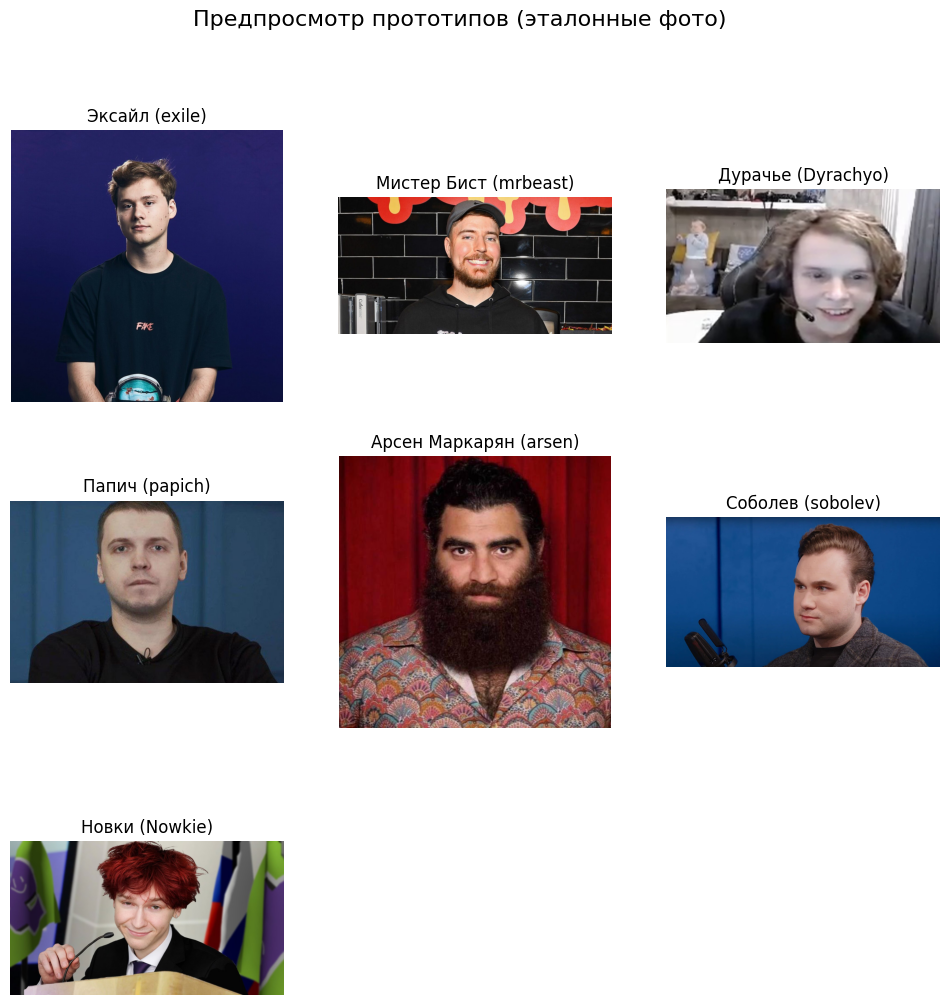

Прототипы построены для: ['exile', 'mrbeast', 'Dyrachyo', 'papich', 'arsen', 'sobolev', 'Nowkie']


In [ ]:
people = pd.read_csv("/content/people.csv")

proto_map = {}
thumbs = []

for _, row in people.iterrows():
    pid, name, url = row["person_id"], row["name"], row["proto_image_url"]
    out_path = PROTO / f"{pid}.jpg"
    ok = dload(url, out_path)
    if not ok:
        print(f"[WARN] Не удалось скачать прототип для {pid} ({name}). Проверь ссылку.")
        continue
    img_bgr = cv2.imread(str(out_path))
    if img_bgr is None:
        print(f"[WARN] Картинка не читается: {out_path}")
        continue
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    thumbs.append((img_rgb, f"{name} ({pid})"))

    f = largest_face(img_bgr)
    if f is None:
        print(f"[WARN] Лицо на прототипе не найдено: {pid} ({name})")
        continue
    proto_map[pid] = f.normed_embedding

n = len(thumbs)
cols = 3
rows = (n + cols - 1) // cols
plt.figure(figsize=(cols*4, rows*4))
for i, (img_rgb, title) in enumerate(thumbs, 1):
    plt.subplot(rows, cols, i)
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title(title)
plt.suptitle("Предпросмотр прототипов (эталонные фото)", fontsize=16)
plt.show()

print("Прототипы построены для:", list(proto_map.keys()))


3) Прототипы: скачивание и усреднённый эмбеддинг

In [ ]:
people = pd.read_csv("/content/people.csv")
proto_dir = RAW/"protos"; proto_dir.mkdir(exist_ok=True)

proto_map = {}
for i, row in people.iterrows():
    pid, name, url = row['person_id'], row['name'], row['proto_image_url']
    outp = proto_dir/f"{pid}_p0.jpg"
    ok = dload(url, outp)
    if not ok:
        print("WARN: cannot download proto", pid);
        continue
    img = cv2.imread(str(outp))
    f = largest_face(img)
    if f is None:
        print("WARN: no face in proto", pid)
        continue
    proto_map[pid] = f.normed_embedding

len(proto_map), list(proto_map.keys())


(7, ['exile', 'mrbeast', 'Dyrachyo', 'papich', 'arsen', 'sobolev', 'Nowkie'])

4) Загрузка видео и нарезка фрагментов

In [ ]:
def download_video(url, out_dir):
    out_dir = Path(out_dir); out_dir.mkdir(parents=True, exist_ok=True)
    cmd = f'yt-dlp -f "mp4[height<=720]" -o "{out_dir}/%(id)s.%(ext)s" {url}'
    run(cmd)
    vids = list(out_dir.glob("*.mp4"))
    return vids[0] if vids else None

def cut_fragment(in_path, start, end, out_path):
    cmd = f'ffmpeg -y -ss {start} -to {end} -i "{in_path}" -c copy "{out_path}" -loglevel error'
    run(cmd)
    return Path(out_path).exists()

frag_rows = []
for _, row in people.iterrows():
    pid, name, vurl, s, e = row['person_id'], row['name'], row['video_url_1'], row['start_1'], row['end_1']
    vfile = download_video(vurl, RAW/pid)
    if vfile is None:
        print("Skip (no video)", pid);
        continue
    outf = FRAG/f"{pid}.mp4"
    if cut_fragment(vfile, s, e, outf):
        frag_rows.append(dict(person_id=pid, name=name, frag=str(outf), url=vurl, start=s, end=e))

len(frag_rows)


>> yt-dlp -f "mp4[height<=720]" -o "/content/celeb_ds/raw/exile/%(id)s.%(ext)s" https://www.youtube.com/watch?v=ANWzk8EBfrk
>> ffmpeg -y -ss 00:00:00 -to 00:10:00 -i "/content/celeb_ds/raw/exile/ANWzk8EBfrk.mp4" -c copy "/content/celeb_ds/fragments/exile.mp4" -loglevel error
>> yt-dlp -f "mp4[height<=720]" -o "/content/celeb_ds/raw/mrbeast/%(id)s.%(ext)s" https://www.youtube.com/watch?v=FjrJ2DJN_pA
>> ffmpeg -y -ss 00:40:00 -to 01:00:00 -i "/content/celeb_ds/raw/mrbeast/FjrJ2DJN_pA.mp4" -c copy "/content/celeb_ds/fragments/mrbeast.mp4" -loglevel error
>> yt-dlp -f "mp4[height<=720]" -o "/content/celeb_ds/raw/Dyrachyo/%(id)s.%(ext)s" https://www.youtube.com/watch?v=HKKI5BEFFTY
>> ffmpeg -y -ss 00:01:00 -to 00:18:00 -i "/content/celeb_ds/raw/Dyrachyo/HKKI5BEFFTY.mp4" -c copy "/content/celeb_ds/fragments/Dyrachyo.mp4" -loglevel error
>> yt-dlp -f "mp4[height<=720]" -o "/content/celeb_ds/raw/papich/%(id)s.%(ext)s" https://www.youtube.com/watch?v=GhXMLM7vUJI
>> ffmpeg -y -ss 00:30:00 -to 00

7

5) Извлечение кадров, детекция и верификация к прототипу

In [ ]:
def extract_frames(video_path, out_dir, step_sec=FRAME_STEP_SEC, max_frames=MAX_FRAMES_PER_VIDEO):
    cap = cv2.VideoCapture(str(video_path))
    fps = cap.get(cv2.CAP_PROP_FPS) or 25
    step = max(1, int(round(step_sec*fps)))
    out_dir = Path(out_dir); out_dir.mkdir(parents=True, exist_ok=True)
    frames = []
    i = -1; kept = 0
    while True:
        if not cap.grab(): break
        i += 1
        if i % step == 0:
            ok, frame = cap.retrieve()
            if not ok: break
            p = out_dir/f"f_{i:07d}.jpg"
            cv2.imwrite(str(p), frame)
            frames.append(p)
            kept += 1
            if kept >= max_frames: break
    cap.release()
    return frames

def detect_faces_on_frame(img_bgr, min_size=MIN_FACE_SIZE):
    faces = app.get(img_bgr) or []
    outs = []
    for f in faces:
        x1,y1,x2,y2 = f.bbox.astype(int)
        if min(x2-x1, y2-y1) < min_size:
            continue
        crop = img_bgr[y1:y2, x1:x2]
        if crop.size == 0:
            continue
        outs.append((crop, f.normed_embedding))
    return outs

meta_rows = []
kept_counts = {}

for it in frag_rows:
    pid, name, vfrag, url = it['person_id'], it['name'], it['frag'], it['url']
    fdir = FRAMES/pid; cdir = CROPS/f"{pid}_{name}"
    fdir.mkdir(exist_ok=True, parents=True); cdir.mkdir(exist_ok=True, parents=True)

    frames = extract_frames(vfrag, fdir)
    kept = 0
    proto = proto_map.get(pid, None)
    for fp in tqdm(frames, desc=f"Faces {pid}"):
        img = cv2.imread(str(fp))
        for crop, emb in detect_faces_on_frame(img):
            if proto is not None and cos_sim(proto, emb) >= VERIFY_COSINE_THR:
                jpg_path = cdir/f"{fp.stem}_face{kept:04d}.jpg"
                cv2.imwrite(str(jpg_path), crop)
                npy_path = cdir/f"{fp.stem}_face{kept:04d}.npy"
                np.save(str(npy_path), emb)

                kept += 1
                meta_rows.append({
                    "person_id": pid, "name": name,
                    "img_path": str(jpg_path.relative_to(ROOT)),
                    "emb_path": str(npy_path.relative_to(ROOT)),
                    "source_url": url
                })
        if kept >= TARGET_PER_IMAGES:
            break
    kept_counts[pid] = kept

meta_df = pd.DataFrame(meta_rows)
META.mkdir(exist_ok=True, parents=True)
meta_df.to_csv(META/"metadata.csv", index=False)
kept_counts, len(meta_df)


Faces Nowkie:  42%|████▏     | 159/380 [00:05<00:07, 30.12it/s]


({'exile': 80,
  'mrbeast': 80,
  'Dyrachyo': 81,
  'papich': 80,
  'arsen': 80,
  'sobolev': 80,
  'Nowkie': 80},
 561)

6) Дедупликация

In [ ]:
def load_emb(rel_npy_path: str):
    p = ROOT / rel_npy_path
    try:
        return np.load(str(p))
    except Exception:
        return None

keep_mask = [True]*len(meta_df)
emb_cache = [None]*len(meta_df)
WINDOW = 200

for i in tqdm(range(len(meta_df)), desc="Dedup"):
    if not keep_mask[i]:
        continue

    pi = meta_df.iloc[i]['emb_path']
    if emb_cache[i] is None:
        emb_cache[i] = load_emb(pi)
    ei = emb_cache[i]

    if ei is None:
        keep_mask[i] = False
        continue

    for j in range(i+1, min(i+1+WINDOW, len(meta_df))):
        if not keep_mask[j]:
            continue

        pj = meta_df.iloc[j]['emb_path']
        if emb_cache[j] is None:
            emb_cache[j] = load_emb(pj)
        ej = emb_cache[j]

        if ej is None:
            keep_mask[j] = False
            continue

        if cos_sim(ei, ej) > DEDUP_THR:
            keep_mask[j] = False

meta_df = meta_df.loc[keep_mask].reset_index(drop=True)
meta_df.to_csv(META/"metadata_dedup.csv", index=False)
len(meta_df)

Dedup: 100%|██████████| 561/561 [00:04<00:00, 131.93it/s]


424

7) Метрики (UMAP, NN-purity, silhouette)

Load embeddings: 100%|██████████| 424/424 [00:00<00:00, 1428.50it/s]
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


NN-purity@5: 1.000 | silhouette(cos): 0.633


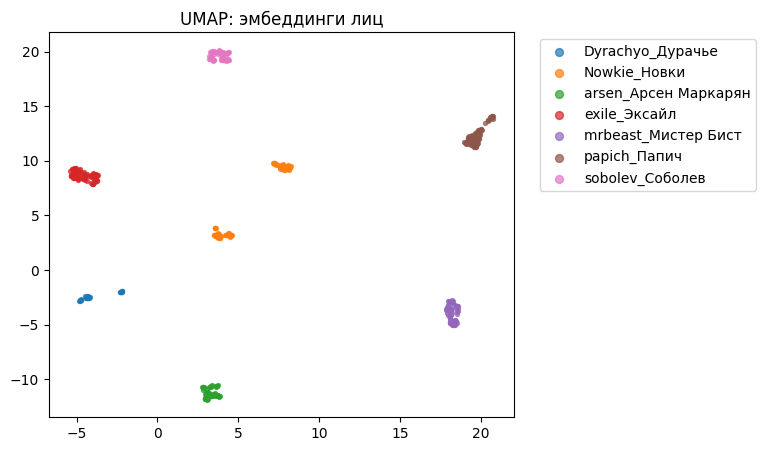

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
import umap

md = meta_df.dropna(subset=["emb_path"]).reset_index(drop=True)

vecs = []
labels = []
class_names = sorted({Path(p).parts[-2] for p in md["img_path"]})
name2id = {name:i for i,name in enumerate(class_names)}

for _, r in tqdm(md.iterrows(), total=len(md), desc="Load embeddings"):
    e = np.load(str(ROOT / r["emb_path"]))
    vecs.append(e)
    cls_name = Path(r["img_path"]).parts[-2]
    labels.append(name2id[cls_name])

vecs = np.stack(vecs) if len(vecs) else np.zeros((0,512), dtype=np.float32)

# NN-purity@5
k = 5
n_neighbors = min(k+1, len(vecs))
nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric="cosine").fit(vecs)
_, ind = nbrs.kneighbors(vecs)
total = 0; correct = 0
for i, neigh in enumerate(ind):
    neigh = neigh[1:]
    total += len(neigh)
    correct += sum(labels[j] == labels[i] for j in neigh)
nn_purity = correct / max(total, 1)

# silhouette (cosine)

sil = silhouette_score(vecs, labels, metric="cosine") if len(set(labels))>1 and len(vecs)>2 else float("nan")
print(f"NN-purity@{k}: {nn_purity:.3f} | silhouette(cos): {sil:.3f}")

#UMAP
proj = umap.UMAP(metric="cosine", random_state=RANDOM_SEED).fit_transform(vecs)
plt.figure(figsize=(6,5))
for cls_id, cls_name in enumerate(class_names):
    m = [lbl==cls_id for lbl in labels]
    if any(m):
        plt.scatter(proj[m,0], proj[m,1], s=8, alpha=0.7, label=cls_name)
plt.legend(markerscale=2, bbox_to_anchor=(1.04,1), loc="upper left")
plt.title("UMAP: эмбеддинги лиц")
plt.show()




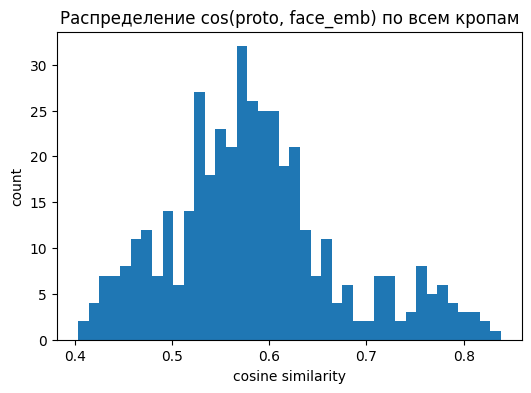

In [ ]:
cos_values = []
md = meta_df.dropna(subset=["emb_path"]).reset_index(drop=True)

for _, r in md.iterrows():
    pid = r["person_id"]
    if pid not in proto_map:
        continue
    e = np.load(str(ROOT / r["emb_path"]))
    cos_values.append(cos_sim(proto_map[pid], e))

plt.figure(figsize=(6,4))
plt.hist(cos_values, bins=40)
plt.title("Распределение cos(proto, face_emb) по всем кропам")
plt.xlabel("cosine similarity")
plt.ylabel("count")
plt.show()



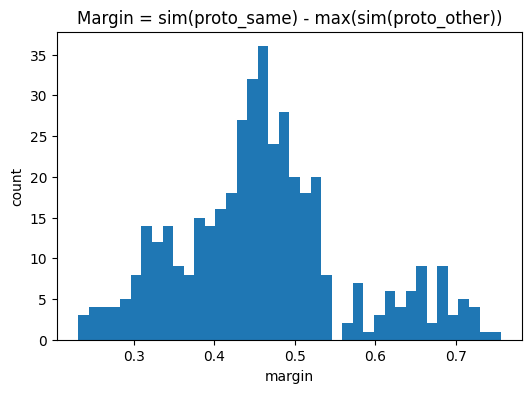

Средний margin: 0.46049956068888587
Процент margin <= 0: 0.0 %


In [ ]:
margins = []
md = meta_df.dropna(subset=["emb_path"]).reset_index(drop=True)

for _, r in md.iterrows():
    pid = r["person_id"]
    e = np.load(str(ROOT / r["emb_path"]))
    own = cos_sim(proto_map[pid], e) if pid in proto_map else -1
    best_other = -1
    for pid2, p_emb in proto_map.items():
        if pid2 == pid:
            continue
        best_other = max(best_other, cos_sim(p_emb, e))
    margins.append(own - best_other)

margins = np.array(margins, dtype=float)
plt.figure(figsize=(6,4))
plt.hist(margins, bins=40)
plt.title("Margin = sim(proto_same) - max(sim(proto_other))")
plt.xlabel("margin")
plt.ylabel("count")
plt.show()

print("Средний margin:", float(np.nanmean(margins)))
print("Процент margin <= 0:", float(100*np.mean(margins <= 0)), "%")



8) Экспорт: ZIP

In [ ]:
shutil.make_archive(str(ROOT/"celebs_dataset"), "zip", ROOT)
print("ZIP:", ROOT/"celebs_dataset.zip")



ZIP: /content/celeb_ds/celebs_dataset.zip
